In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import PIL

import torch
from torch.utils.data import Dataset, DataLoader

# Transforms
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
)

# Label Binarization
from sklearn.preprocessing import LabelBinarizer

# Data splits
from sklearn.model_selection import train_test_split

# Model
from monai.networks.nets import DenseNet121

# Decollation
from monai.data import decollate_batch

# Metrics
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report

# Print config
from monai.config import print_config
print_config()

# Set deterministic training for reproducibility
SEED = 0
from monai.utils import set_determinism
set_determinism(seed=SEED)

MONAI version: 0.8.0
Numpy version: 1.21.2
Pytorch version: 1.10.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 7.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
def listdir_nohidden(path):
    """
    List files in directory ignoring hidden files (starting with a point)

    Args:
        path (str): Path to directory

    Yields:
        generator object
    """

    for file in sorted(os.listdir(path)):
        if not file.startswith('.'):
            yield file

def load_data(path):
    
    labels = []
    filepaths = []
    for category in listdir_nohidden(path):
        if os.path.isdir(os.path.join(path, category)):
            num_files_in_category = 0
            for file in listdir_nohidden(os.path.join(path, category)):
                num_files_in_category += 1
                labels.append(category)
                filepaths.append(os.path.join(path, category, file))

    return labels, filepaths

def get_image_dimensions(path):
    
    return PIL.Image.open(path).size
    
def binarize_labels(labels):

    lb = LabelBinarizer()
    encoded_labels = lb.fit(labels).transform(labels)
    return torch.tensor(encoded_labels, dtype=torch.float32), lb.classes_

In [3]:
# Set directories
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, 'data/MedNIST')

# Load data
labels, filepaths = load_data(data_dir)

# Create data dict
data_dict = {'label': labels, 'filepath': filepaths}

# Data exploration
num_files = len(data_dict['label'])
print(f'Total number of files: {num_files}')
unique, counts = np.unique(labels, return_counts=True)
num_classes = len(unique)
print(f'Total number of classes: {num_classes}')
print(f'Files per classes: \n {dict(zip(unique, counts))}')
image_width, image_height = get_image_dimensions(data_dict['filepath'][0])
print(f"Image dimensions: {image_width} x {image_height}")

Total number of files: 58954
Total number of classes: 6
Files per classes: 
 {'AbdomenCT': 10000, 'BreastMRI': 8954, 'CXR': 10000, 'ChestCT': 10000, 'Hand': 10000, 'HeadCT': 10000}
Image dimensions: 64 x 64


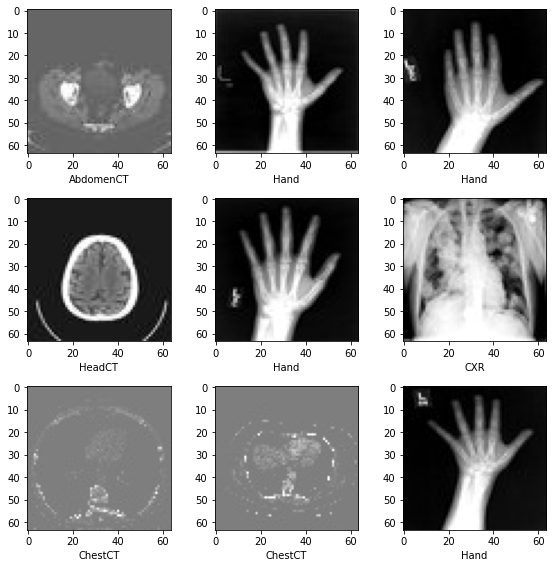

In [4]:
# Plot example images
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_files, size=9)):
    im = PIL.Image.open(data_dict['filepath'][k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(data_dict['label'][k])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [5]:
# Prepare data splits
test_ratio = 0.2
train_ratio = 1-test_ratio
val_factor = test_ratio/train_ratio  # 0.25 x 0.8 = 0.2
val_ratio = val_factor * train_ratio
X_train, X_test, y_train, y_test = train_test_split(data_dict['filepath'], data_dict['label'], test_size=test_ratio, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_factor, random_state=SEED)
print(f'Training: {train_ratio}, Validation: {val_ratio}, Test: {test_ratio}')
print(f'Training count: {len(X_train)}')
print(f'Validation count: {len(X_val)}')
print(f'Test count: {len(X_test)}')

# Binarize labels
y_train, _ = binarize_labels(y_train)
y_val, _ = binarize_labels(y_val)
y_test, _ = binarize_labels(y_test)

Training: 0.8, Validation: 0.2, Test: 0.2
Training count: 35372
Validation count: 11791
Test count: 11791


In [6]:
# Define MONAI transforms, preprocess data
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

validation_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        EnsureType()
    ]
)

y_prediction_transforms = Compose([EnsureType(), Activations(softmax=True)])
y_true_transforms = Compose([EnsureType()])

In [7]:
# Define Dataset and Data Loader
class MedNISTDataset(Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(X_train, y_train, train_transforms)
train_loader = DataLoader(train_ds, batch_size=320, shuffle=True, num_workers=10)

validation_ds = MedNISTDataset(X_val, y_val, validation_transforms)
validation_loader = DataLoader(validation_ds, batch_size=320, num_workers=10)

test_ds = MedNISTDataset(X_test, y_test, validation_transforms)
test_loader = DataLoader(test_ds, batch_size=320, num_workers=10)

In [8]:
# Define network and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 20
val_interval = 1
auc_metric = ROCAUCMetric()

In [9]:
# Model training
step_interval = 50
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
epoch_acc_values = []
val_loss_values = []
val_acc_values = []
metric_values = []

print("-" * 10)
print('Start model training')
print("-" * 10)
print(f'Train on {len(X_train)} samples')

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    step = 0
    for ind, batch_data in enumerate(train_loader):
        step += 1
        training_images, training_labels = batch_data[0].to(
            device), batch_data[1].to(device)
        optimizer.zero_grad()
        predictions = model(training_images)
        loss = loss_function(predictions, training_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        acc_value = torch.eq(predictions.argmax(
            dim=1), training_labels.argmax(dim=1))
        acc_metric = acc_value.sum().item() / len(acc_value)
        epoch_acc += acc_metric

        if (ind + 1) % step_interval == 0:
            print(f"Step: {step}/{len(train_loader)} - "
                  f"loss: {loss.item():.4f} - "
                  f"acc: {acc_metric:.4f}")

    epoch_loss /= step
    epoch_acc /= step
    epoch_loss_values.append(epoch_loss)
    epoch_acc_values.append(epoch_acc)
    print(f"Average training loss: {epoch_loss:.4f} - "
          f"Average training accuracy: {epoch_acc:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y_true = torch.tensor([], dtype=torch.long, device=device)
            for validation_data in validation_loader:
                validation_images, validation_labels = validation_data[0].to(
                    device), validation_data[1].to(device)
                predictions = model(validation_images)
                y_pred = torch.cat([y_pred, predictions], dim=0)
                y_true = torch.cat([y_true, validation_labels], dim=0)

                # Calculate validation loss
                val_loss = loss_function(predictions, validation_labels)
                val_epoch_loss += val_loss.item()
            # Total validation loss by dividing by number of batches
            val_epoch_loss /= len(validation_loader)
            val_loss_values.append(val_epoch_loss)

            acc_value = torch.eq(y_pred.argmax(dim=1),
                                 y_true.argmax(dim=1))
            acc_metric = acc_value.sum().item() / len(acc_value)
            val_acc_values.append(acc_metric)

            y_onehot = [y_true_transforms(i)
                        for i in decollate_batch(y_true)]
            y_pred_act = [y_prediction_transforms(
                i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)

            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, 'best_metric_model.pth'))
                print("Saved new best metric model")

            print(f"Average validation loss: {val_epoch_loss:.4f} - "
                  f"Average validation accuracy: {acc_metric:.4f}")
            print(f"Current AUC: {result:.4f}"
                  f" - Best AUC: {best_metric:.4f}"
                  f" at Epoch: {best_metric_epoch}"
                  )
print(
    f"Train completed, best metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
Start model training
----------
Train on 35372 samples
----------
Epoch 1/20
Step: 50/111 - loss: 0.8989 - acc: 0.9156
Step: 100/111 - loss: 0.4304 - acc: 0.9719
Average training loss: 0.8995 - Average training accuracy: 0.8712
Saved new best metric model
Average validation loss: 0.4056 - Average validation accuracy: 0.9472
Current AUC: 0.9955 - Best AUC: 0.9955 at Epoch: 1
----------
Epoch 2/20
Step: 50/111 - loss: 0.2206 - acc: 0.9844
Step: 100/111 - loss: 0.1540 - acc: 0.9719
Average training loss: 0.2353 - Average training accuracy: 0.9702
Saved new best metric model
Average validation loss: 0.1520 - Average validation accuracy: 0.9773
Current AUC: 0.9994 - Best AUC: 0.9994 at Epoch: 2
----------
Epoch 3/20
Step: 50/111 - loss: 0.0961 - acc: 0.9938
Step: 100/111 - loss: 0.0841 - acc: 0.9812
Average training loss: 0.1075 - Average training accuracy: 0.9836
Saved new best metric model
Average validation loss: 0.0804 - Average validation accuracy: 0.9897
Current AUC: 0.9999

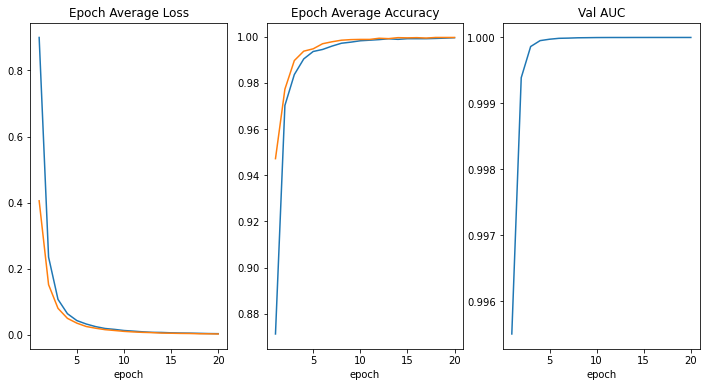

In [10]:
# Plot Loss and Validation AUC
plt.figure("train", (12, 6))
plt.subplot(1, 3, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
val_x = [i + 1 for i in range(len(val_loss_values))]
val_y = val_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.plot(val_x, val_y)

plt.subplot(1, 3, 2)
plt.title("Epoch Average Accuracy")
x = [i + 1 for i in range(len(epoch_acc_values))]
y = epoch_acc_values
val_x = [i + 1 for i in range(len(val_acc_values))]
val_y = val_acc_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.plot(val_x, val_y)

plt.subplot(1, 3, 3)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [11]:
# Evaluate the model on test dataset
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].argmax().item())
            y_pred.append(pred[i].item())

In [12]:
print(classification_report(y_true, y_pred, target_names=unique, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9990    1.0000    0.9995      1964
   BreastMRI     0.9994    1.0000    0.9997      1808
         CXR     0.9990    0.9995    0.9993      2016
     ChestCT     1.0000    1.0000    1.0000      1993
        Hand     0.9995    0.9985    0.9990      2001
      HeadCT     1.0000    0.9990    0.9995      2009

    accuracy                         0.9995     11791
   macro avg     0.9995    0.9995    0.9995     11791
weighted avg     0.9995    0.9995    0.9995     11791

